In [2]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.impute import  SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import cross_validate
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from sklearn.base import clone
import shap
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix



c:\Users\17788\OneDrive\Documents\Natalia\python_work\Data Analysis\Credit Risk Prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Credit Risk Prediction Project


The risk in credit and lending provided by banks to individuals lies in the potential for default, where the borrower is unable to fully repay their loans. Banks must therefore assess whether individuals have the capacity to reimburse their loans to ensure that these financial investments yield positive outcomes. This is important for ensuring sound financial decision-making.

The goal of this project is to develop a model that assesses whether an individual is likely to fail to repay their debts on time. This credit scoring algorithm will be implemented as a supervised machine learning classification task, using the "Give Me Some Credit" dataset provided by Kaggle ([Link](https://www.kaggle.com/c/GiveMeSomeCredit/overview))(1). 

This dataset provides relevant features such as prior failure to repay loans on time, monthly income, lines of credit, number of dependents and number of current loans. The model will predict the whether an individual will experience a delinquency of 90 days or worse. Among the features, the most indicative of credit default is expected to be previous occurrences of financial stress, demonstrated by repeated failures to repay loans on time. 



(1) Credit Fusion and Will Cukierski. Give Me Some Credit. https://kaggle.com/competitions/GiveMeSomeCredit, 2011. Kaggle.

In [3]:
credit_traindf = pd.read_csv("data/cs-training.csv")
credit_testdf = pd.read_csv("data/cs-test.csv")

In [4]:
credit_traindf

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


#### **Dataset Cleaning :**
To simplify downstream analysis, feature names were shortened and renamed. Additionally, a column labeled 'Unnamed: 0' was removed from the dataset, as it appears to be an artifact or mistake.

In [5]:
new_columns = {
    "SeriousDlqin2yrs" : "target",
    "RevolvingUtilizationOfUnsecuredLines" : "credit_util_ratio",
    "NumberOfTime30-59DaysPastDueNotWorse" : "mod_late_count_2yr",
    "DebtRatio": "debt_ratio",
    "MonthlyIncome" : "monthly_income",
    "NumberOfOpenCreditLinesAndLoans" : "credit_loans_count", 
    "NumberOfTimes90DaysLate" : "crit_late_count", 
    "NumberRealEstateLoansOrLines" : "real_estate_count",
    "NumberOfTime60-89DaysPastDueNotWorse"  :"sev_late_count_2yr",
    "NumberOfDependents" : "dependent_count"
}


credit_traindf = credit_traindf.rename(columns = new_columns)
credit_testdf = credit_testdf.rename(columns = new_columns)

credit_traindf

,Unnamed: 0,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [6]:
credit_traindf = credit_traindf.drop(columns = ["Unnamed: 0"])
credit_testdf = credit_testdf.drop(columns = ["Unnamed: 0"])

credit_traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   target              150000 non-null  int64  
 1   credit_util_ratio   150000 non-null  float64
 2   age                 150000 non-null  int64  
 3   mod_late_count_2yr  150000 non-null  int64  
 4   debt_ratio          150000 non-null  float64
 5   monthly_income      120269 non-null  float64
 6   credit_loans_count  150000 non-null  int64  
 7   crit_late_count     150000 non-null  int64  
 8   real_estate_count   150000 non-null  int64  
 9   sev_late_count_2yr  150000 non-null  int64  
 10  dependent_count     146076 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 12.6 MB


In [7]:
rel = ((credit_traindf["debt_ratio"] > 1) & credit_traindf["monthly_income"].isna()).sum()
nan_count = credit_traindf["monthly_income"].isna().sum()
greater_1 = (credit_traindf["debt_ratio"] > 1).sum()

print(f"There are {rel} instances where debt ratio is above 1 and monthly income is NaN")
print(f"There are {nan_count} total instances of NaN in the monthly income feature")
print(f"There are {greater_1} total instances of a debt ratio of > 1")

There are 27904 instances where debt ratio is above 1 and monthly income is NaN
There are 29731 total instances of NaN in the monthly income feature
There are 35137 total instances of a debt ratio of > 1


#### **Observations :**

- The dataset is large, with 150,000 rows and all numerical features.
- credit_util_ratio, debt_ratio, and monthly_income are continuous variables and may require scaling. The remaining features are discrete.
- debt_ratio and credit_util_ratio containg some values over 1, which is unusual and could indicate outliers/data entry errors.
- Missing values are present in both monthly_income and dependents_count.
- monthly_income is a concern: approximately 20% of its values are missing.
    - This is particularly problematic because debt_ratio is calculated as: \
        (monthly debt payments + alimony + living costs) / monthly income \
    Missing values in monthly_income could therefore distort the debt_ratio feature.


- I investigated whether debt_ratio > 0 was associated with missing monthly_income, but the counts do not align, which suggests the missing income values may not be the cause for the elevated debt ratios.

### **1. Exploratory Data Analysis**

> The dataset shows a moderate class imbalance: ~93% negative cases and ~7% positive. This imbalance can increase the risk of overfitting, particularly by reducing the model’s ability to generalize to the minority class. Downstream models and evaluation metrics must account for this through stratified sampling, class-weighting, or using metrics like F1-score.

> Many features contain extreme outliers, as shown in the summary statistics and boxplots. Notably, 'credit_util_ratio' and 'debt_ratio' show values above 1, which is atypical for ratio features. Count-based deliquency features ('mod_late_count_2yr', 'crit_late_count', 'sev_late_count_2yr') are mostly zero, with a few high outliers.'monthly_income' also contains some extreme outliers. The 'age' feature includes implausible values (0 and over 100), which are liekly data errors and shold be excluded.

> Count-based features are heavily right-skewed, with most values near zero and long tails. This skew can reduce interpretability and performance in linear models. Discretization or binning may better capture the relationship between these features and the target, especially since they show non-linear associations with delinquency rate. While this may benefit linear models, it’s less important for tree-based models.

> The correlation heatmap indicates strong positive correlations amoung the deliquency count features ('mod_late_count_2yr', 'crit_late_count', 'sev_late_count_2yr'). These relationships can risk multicolinearity, leading to overfitting and reduced interpretability (model can be confused on which feature is contributing to the prediction).

> Feature-target correlation analysis shows that delinquency count features ('mod_late_count_2yr', 'crit_late_count', 'sev_late_count_2yr') are most positively correlated with the target. In contrast, 'age' contains the strongest negative correlation, comprable to 'sev_late_count_2yr'.

Individuals in this dataset with 90+ days past due Delinquency: 10026 (6.68%)
Individuals in this dataset without 90+ days past due Delinquency: 139974 (93.32%)


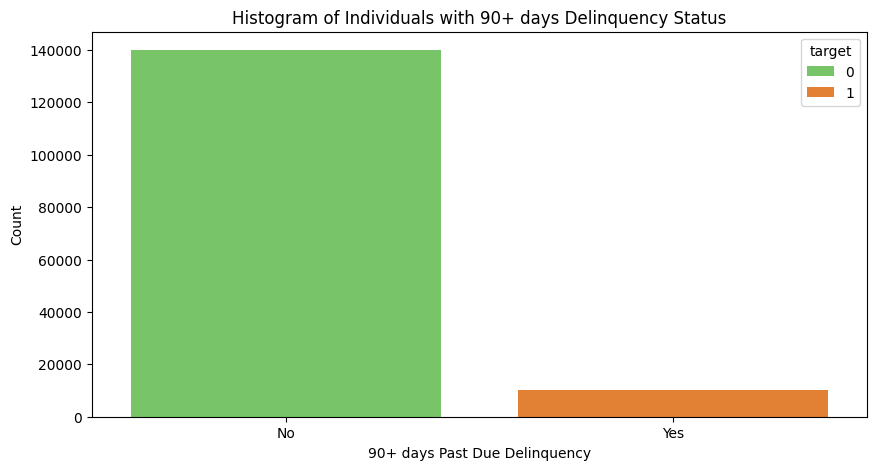

In [8]:
# Make a histogram displaying the counts of the target column

yes_cases = credit_traindf[credit_traindf["target"] == 1].shape[0]
no_cases = credit_traindf[credit_traindf["target"] == 0].shape[0]
total = credit_traindf.shape[0]

yes_cases_percent, no_cases_percent = (yes_cases / total)*100, (no_cases / total)*100

print(f"Individuals in this dataset with 90+ days past due Delinquency: {yes_cases} ({yes_cases_percent:.2f}%)")
print(f"Individuals in this dataset without 90+ days past due Delinquency: {no_cases} ({no_cases_percent:.2f}%)")


plt.figure(figsize = (10,5))
sns.countplot(x = "target",
              data = credit_traindf,
              hue = "target", 
              palette={0 : "#6DD558", 1 : "#FF7C17"})
plt.title("Histogram of Individuals with 90+ days Delinquency Status")
plt.xlabel("90+ days Past Due Delinquency")
plt.ylabel("Count")
plt.xticks(ticks = [0, 1], labels=['No', 'Yes'])
plt.show()

In [9]:
credit_traindf.describe()

,target,credit_util_ratio,age,mod_late_count_2yr,debt_ratio,monthly_income,credit_loans_count,crit_late_count,real_estate_count,sev_late_count_2yr,dependent_count
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


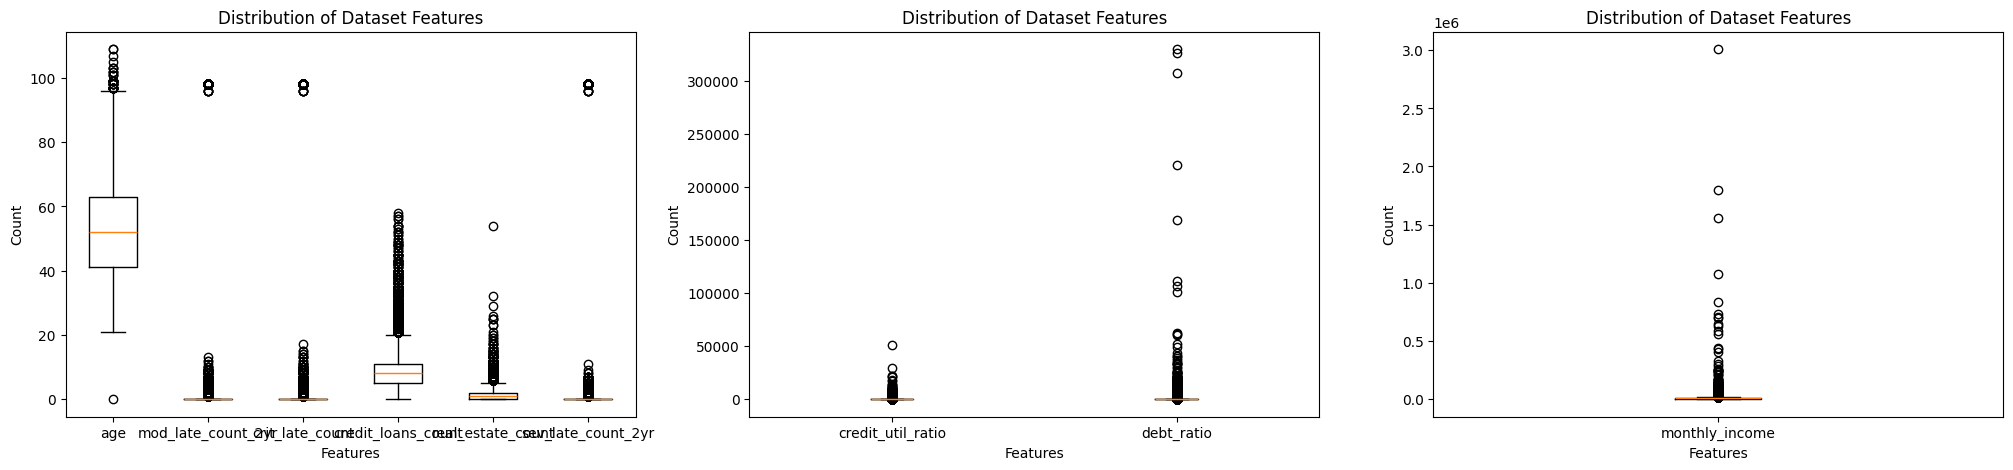

In [10]:
columns_0 = credit_traindf[["age", "mod_late_count_2yr", "crit_late_count", "credit_loans_count", "real_estate_count", "sev_late_count_2yr", ]]
columns_1 = credit_traindf[["credit_util_ratio", "debt_ratio", ]]

fig, ax = plt.subplots(1,3, figsize=(25,5))

ax[0].set_title("Distribution of Dataset Features")
ax[0].boxplot(columns_0)
ax[0].set_xticks(ticks = range(1,7), labels = columns_0)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Features")

ax[1].set_title("Distribution of Dataset Features")
ax[1].boxplot(columns_1)
ax[1].set_xticks(ticks = range(1,3), labels = columns_1)
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Features")

ax[2].set_title("Distribution of Dataset Features")
ax[2].boxplot(x = credit_traindf["monthly_income"].dropna())
ax[2].set_xticklabels(["monthly_income"])
ax[2].set_ylabel("Count")
ax[2].set_xlabel("Features")


plt.show()

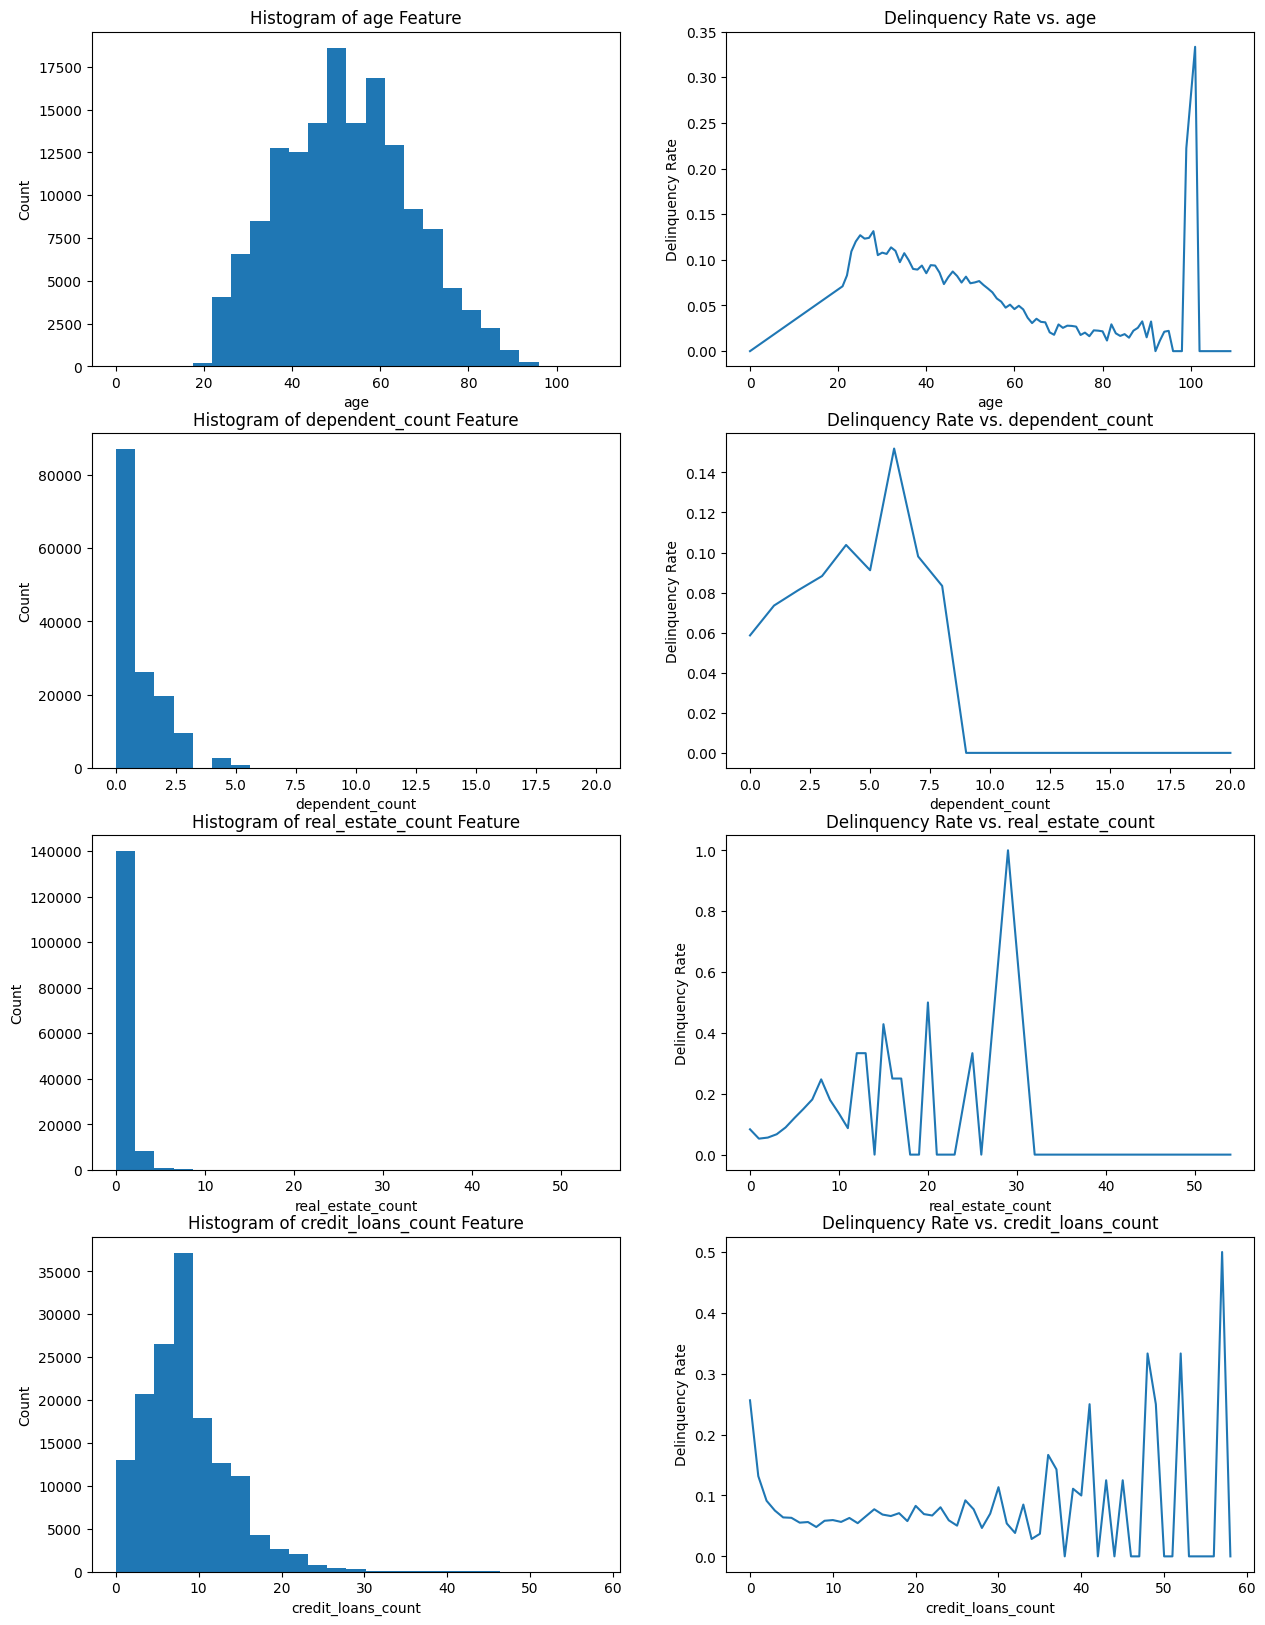

In [11]:
cols_discrete = {"age":[0,1],
                 "dependent_count":[2,3],
                 "real_estate_count":[4,5],
                 "credit_loans_count":[6,7],
                }

fig, ax = plt.subplots(4,2, figsize = (15,20))
ax = ax.flatten()

for key, val in cols_discrete.items() : 
    
    ax[val[0]].hist(credit_traindf[key], bins = 25)
    ax[val[0]].set_xlabel(f"{key}")
    ax[val[0]].set_ylabel("Count")
    ax[val[0]].set_title(f"Histogram of {key} Feature") 
    
    groups = credit_traindf.groupby(key)["target"].mean()
    ax[val[1]].plot(groups.index, groups.values)
    ax[val[1]].set_xlabel(f"{key}")
    ax[val[1]].set_ylabel("Delinquency Rate")
    ax[val[1]].set_title(f"Delinquency Rate vs. {key}")

plt.show()
    

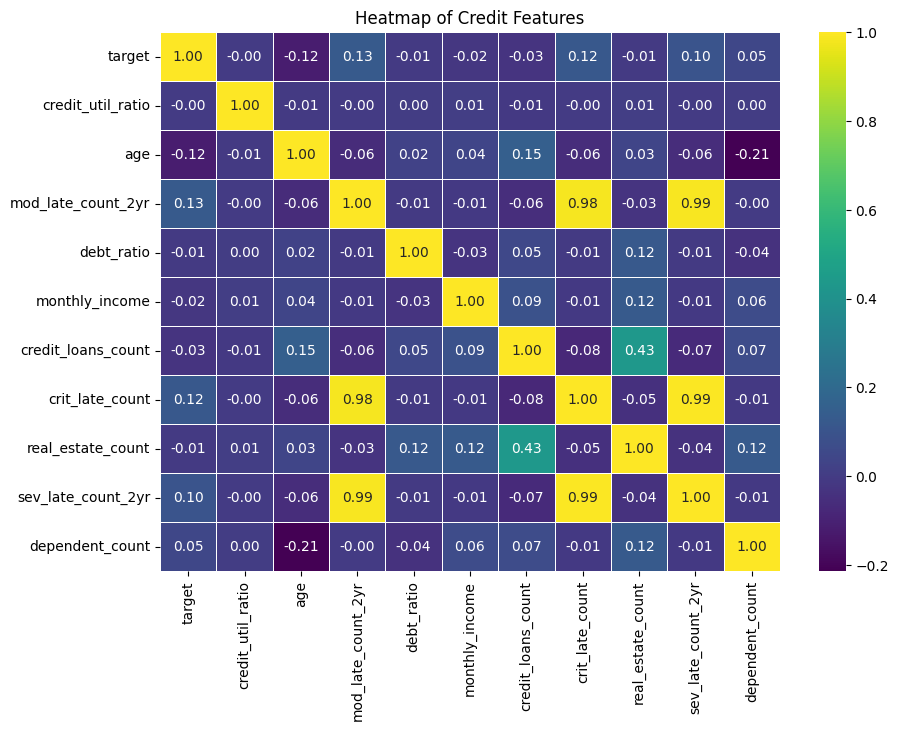

In [12]:
# Create a Heatmap to show correlations between features 
corr_subset = credit_traindf[credit_traindf.columns[:1000]].corr()

plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f", linewidths=.5) 
plt.title('Heatmap of Credit Features') 
plt.show()

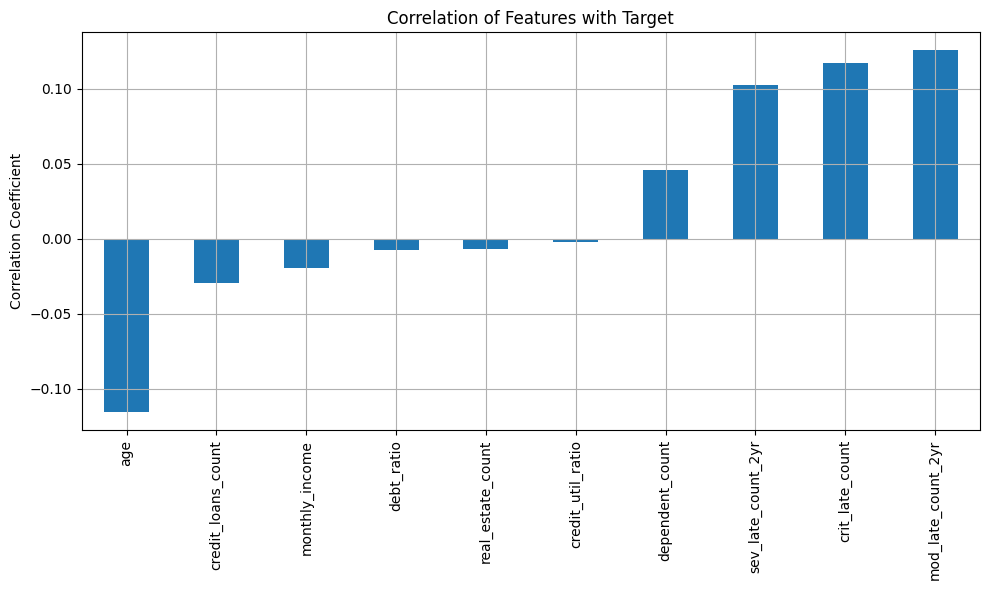

In [13]:
# plot correlations between features and the target

correlations = credit_traindf.corr(numeric_only=True)["target"].sort_values()
correlations = correlations.drop('target')

# Plot
plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.title("Correlation of Features with Target")
plt.ylabel("Correlation Coefficient")
plt.grid(True)
plt.tight_layout()
plt.show()

### **2. Feature Engineering + Preprocessing**

Before splitting the training set, the following preprocessing steps were applied:
1. **Binary Encoding of Count Features:** Delinquency count features and related dependent count variables were converted into binary indicators. The majority of the values in these features are 0 and only the outliers are above 1. This change simplifies thier use in linear models. 
2. **Clipping Implausible Values:** The 'age' feature is clipped to remove the unsual outliers (0 and over 100).
3. **Feature Binning:** The 'age' feature and various count-based features (including 'credit_loans_count' and 'real_estate_count') were binned into four discrete intervals. This improves interpretability and helps linear models. 
4. **Missingness Indicator:** A binary flag was added to indicate missing values in the 'monthly_income' feature.
5. **Capping Ratio Features and Outlier Flags:** Ratio features (e.g., 'credit_util_ratio', 'debt_ratio') were capped at a maximum of 1, since values above 1 are considered outliers. Corresponding binary outlier indicator features were created.

After preprocessing, a correlation heatmap was generated. The least informative feature, 'debt_ratio_outliers' (which had high correlation with 2 other variables and neglibible relationship with the target), was removed.

In [14]:
traindf = credit_traindf.copy()
testdf = credit_testdf.copy()

In [15]:
def preprocess(df) :

    '''Before splitting, perform preprocessing '''

    # Make the columns binary (0: for zero counts, 1: for 1+ counts) ✓✓
    make_binary_cols = ["crit_late_count", "mod_late_count_2yr", "sev_late_count_2yr", "dependent_count"]

    for col in make_binary_cols : 
        df[col] = (df[col] > 0).astype(int)
        #(df[col] > 0) returns a series of booleans, which is turned into 1 (True) or 0 (False)

    # Remove bad rows from the age column (above 100, less than 18 years old) ✓✓
    df["age_clipped"] = df["age"].clip(upper=100, lower=18)
    df = df.drop(columns = "age") 

    # Binning Age, credit loans, real estate bin ✓✓
    df['age_bin'] = pd.cut(df['age_clipped'], 
                           bins=[-float('inf'), 30, 45, 60, float('inf')], 
                           labels=False)
    
    df['credit_bin'] = pd.cut(df['credit_loans_count'], 
                              bins=[-float('inf'), 5, 25, 40, float('inf')], 
                              labels=False)

    df['real_estate_bin'] = pd.cut(df['real_estate_count'], 
                                   bins=[-float('inf'), 10, 20, 30, float('inf')], 
                                   labels=False)


    remove_col = ["age_clipped", "credit_loans_count", "real_estate_count"]
    df = df.drop(columns = remove_col)

    # Add a missingness flag for the monthly_income column ✓✓
    df["mon_income_miss"] = df["monthly_income"].isna().astype(int)

    # cap the ratio columns at 1, and flag any rows > 1 in a new feature ✓✓
    ratio_cols = ["credit_util_ratio", "debt_ratio"]

    for col in ratio_cols : 
        df[f"{col}_outliers"] = (df[col] > 1).astype(int)
        df.loc[df[col] > 1, col] = 1


    return df

In [16]:
traindf_preprocessed = preprocess(traindf)
testdf_preprocessed = preprocess(testdf)

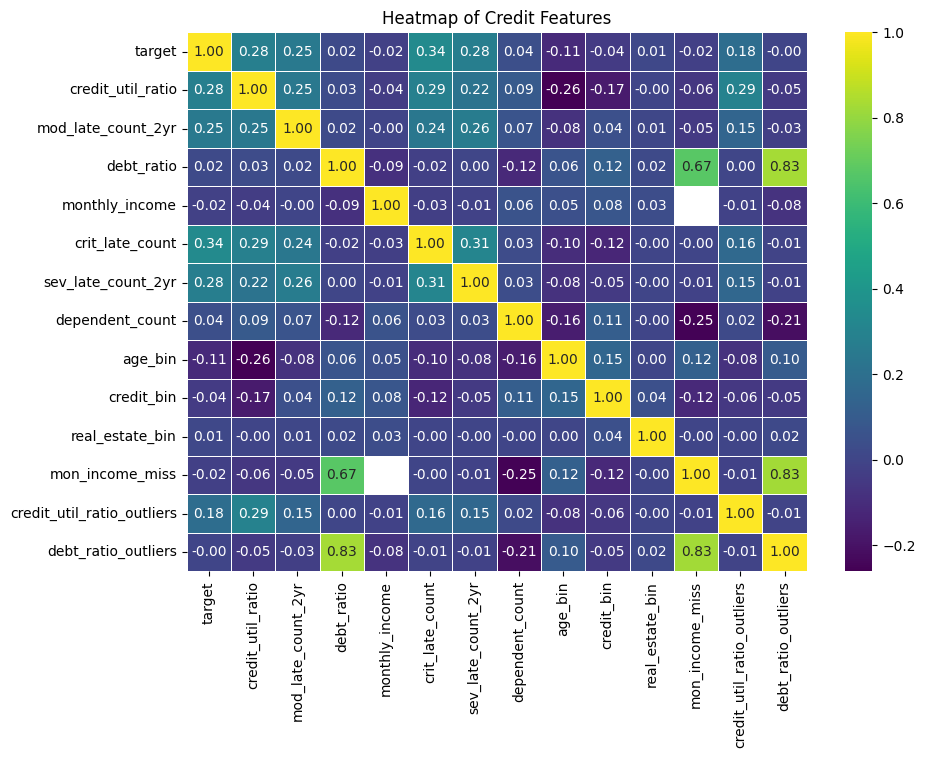

In [17]:
# Create a Heatmap to show correlations between features 
corr_subset = traindf_preprocessed[traindf_preprocessed.columns[:1000]].corr()

plt.figure(figsize=(10, 7)) 
sns.heatmap(corr_subset, annot=True, cmap='viridis', fmt=".2f", linewidths=.5) 
plt.title('Heatmap of Credit Features') 
plt.show()

In [18]:
traindf_preprocessed = traindf_preprocessed.drop(columns = ["debt_ratio_outliers"])
testdf_preprocessed = testdf_preprocessed.drop(columns = ["debt_ratio_outliers"])

### **3. Train-Test Splitting and Processing**

The training set was split into test (30%) and train (70%) datasets. The feature for 'monthly_income' was adjusted using log1p to address the outliers. 

In [19]:
# Split the training set into a testing and training set to get validation
X = traindf_preprocessed.drop(columns = ["target"])
y = traindf_preprocessed["target"]

# splitting on 0.5 because we have a lot of data and it's slowing down the downstream processing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [20]:
X_train["monthly_income_log"] = np.log1p(X_train["monthly_income"])
X_test["monthly_income_log"] = np.log1p(X_test["monthly_income"])

X_train = X_train.drop(columns = ["monthly_income"])
X_test = X_test.drop(columns = ["monthly_income"])

### **4. Generate Column Transformer and Scoring Functions**

Features are separated accourding to the required transformers.

In [21]:
X_train.columns

Index(['credit_util_ratio', 'mod_late_count_2yr', 'debt_ratio',
       'crit_late_count', 'sev_late_count_2yr', 'dependent_count', 'age_bin',
       'credit_bin', 'real_estate_bin', 'mon_income_miss',
       'credit_util_ratio_outliers', 'monthly_income_log'],
      dtype='object')

In [22]:
scaling_cols = ["credit_util_ratio","debt_ratio","monthly_income_log"]
oh_cols = ["age_bin", "credit_bin", "real_estate_bin"]
binary_cols = ["mod_late_count_2yr", "crit_late_count", "sev_late_count_2yr", "credit_util_ratio_outliers", "mon_income_miss", "dependent_count"]


# Pipelines
scaling_pipeline = make_pipeline(
    SimpleImputer(),
    StandardScaler()
)

oh_pipeline = make_pipeline(
    SimpleImputer(),
    OneHotEncoder(sparse_output=False, handle_unknown="ignore")
)

binary_pipeline = OneHotEncoder(drop='if_binary', dtype=int)

# Column transformer
preprocessor = make_column_transformer(
    (scaling_pipeline, scaling_cols),
    (oh_pipeline, oh_cols),
    (binary_pipeline, binary_cols),

    verbose_feature_names_out="{feature_name}"
  #  ("drop", drop_cols)
)

In [23]:
def cross_validate_mean_std(model, X, y) :
    '''Performs 5-fold cross-validation and returns train/test mean ± std as formatted strings.'''

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scr = cross_validate(model, X, y, cv=cv, return_train_score=True, scoring=("f1", "precision", "recall"))

    result = {}

    result = {
        "test_score_f1" : f"{scr['test_f1'].mean():.2f} +/- {scr['test_f1'].std():.3f}",
        "train_score_f1" : f"{scr['train_f1'].mean():.2f} +/- {scr['train_f1'].std():.3f}",

        "test_score_precision" : f"{scr['test_precision'].mean():.2f} +/- {scr['test_precision'].std():.3f}",
        "train_score_precision" : f"{scr['train_precision'].mean():.2f} +/- {scr['train_precision'].std():.3f}",

        "test_score_recall" : f"{scr['test_recall'].mean():.2f} +/- {scr['test_recall'].std():.3f}",
        "train_score_recall" : f"{scr['train_recall'].mean():.2f} +/- {scr['train_recall'].std():.3f}"
    }

    return result

In [24]:
# Dictionary to keep track of the scores
scores = {}

### **5. Baseline Model - Dummy Classifier, Decision Tree**

The dummy classifier exhibits poor predicition scores (<50%) for f1 and precision metrics, and approximatly 50% recall. These scores are simular across training and testing results, which does not indicate overfitting. Conversly, the decision tree yeilded strong results for training scores (approximately 95-99%) but shows significantly lower scores on the test set (~20%), suggesting this model is overfitting to the training data. 

In [25]:
# The results are expected if the dummy are choosing the 0 class more often
dummy = DummyClassifier(strategy="uniform")
dummy_pipe = make_pipeline(preprocessor, dummy)

scores["Dummy"] = cross_validate_mean_std(dummy_pipe, X_train, y_train)

In [26]:
pipe_dt = make_pipeline(preprocessor, DecisionTreeClassifier(
    random_state=123
))

scores["Decision Tree"] = cross_validate_mean_std(pipe_dt, X_train, y_train)
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
Dummy,0.12 +/- 0.003,0.12 +/- 0.001,0.07 +/- 0.002,0.07 +/- 0.001,0.50 +/- 0.012,0.50 +/- 0.008
Decision Tree,0.25 +/- 0.004,0.97 +/- 0.001,0.25 +/- 0.003,0.99 +/- 0.001,0.25 +/- 0.006,0.95 +/- 0.002


### **6. Linear Model - Linear Regression**

The linear regression model serves as a secondary baseline algorithm. The results show that for various values of the C hyperparamter, f1 and precision are consistent, showing scores of approximately 30% and 20%, respectively. Recall is consistently ~70 % across C values. The scores are the same for training and testing results, suggesting the model does not overfit/underfit. The model works best with C = 0.01, where recall = 0.74, precision = 0.21 and f1 = 0.33 (for both training and testing). The high recall indicates the model performs well in minimizing false negatives, and identifies positive cases well. Low precision indicates the model may be measuring higher false positives. 

Note that the model contained the parameter class_weight="balanced" to account for the class imbalance. 

In [27]:
c_dict = {
    "C" : [0.0001, 0.001, 0.01, 0.1, 1]
}

linear_model_dict = {}

for c in c_dict["C"] :
    model = LogisticRegression(C = c, class_weight='balanced', max_iter=1000)
    linear_pipe = make_pipeline(preprocessor,  model)
    linear_model_dict[f"Logistic Regression C={c}"] = cross_validate_mean_std(linear_pipe, X_train, y_train)

pd.DataFrame(linear_model_dict).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
Logistic Regression C=0.0001,0.29 +/- 0.004,0.29 +/- 0.001,0.18 +/- 0.003,0.18 +/- 0.001,0.72 +/- 0.010,0.72 +/- 0.001
Logistic Regression C=0.001,0.31 +/- 0.004,0.31 +/- 0.001,0.20 +/- 0.003,0.20 +/- 0.001,0.74 +/- 0.006,0.74 +/- 0.002
Logistic Regression C=0.01,0.33 +/- 0.004,0.33 +/- 0.001,0.21 +/- 0.003,0.21 +/- 0.001,0.74 +/- 0.008,0.74 +/- 0.002
Logistic Regression C=0.1,0.33 +/- 0.005,0.33 +/- 0.001,0.21 +/- 0.003,0.21 +/- 0.001,0.74 +/- 0.009,0.74 +/- 0.001
Logistic Regression C=1,0.33 +/- 0.005,0.33 +/- 0.001,0.21 +/- 0.003,0.21 +/- 0.001,0.74 +/- 0.010,0.74 +/- 0.001


In [28]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    C=0.01
))

scores["Logistic Reg."] = cross_validate_mean_std(pipe_lr, X_train, y_train)

### **7. Ensembles**

All ensemble algorithms trained on the dataset produced similar results across both the training and test sets. While training scores were high (averaging 94% for f1, precision, and recall), test performance was poor, with all metrics falling below 50%. This discrepancy indicates significant overfitting and limited generalizability to unseen data.

In comparison to earlier models, the ensemble methods performed similarly to the baseline Decision Tree in terms of f1 score and recall on the test set. Given this, logistic regression outperformed all ensemble models in generalization performance.

Because the ensemble models showed nearly identical behavior, further analysis focused on the RandomForestClassifier and HistGradientBoostingClassifier.
Note: All models were configured to account for class imbalance, but none have undergone hyperparameter tuning yet. 

In [29]:
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(
    n_jobs = -1,
    random_state = 123,
    n_estimators=100,
    class_weight = "balanced"
))

pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(
    random_state=123, 
    verbose=-1,
    is_unbalance=True
))

pipe_histGB = make_pipeline(preprocessor, HistGradientBoostingClassifier(
    random_state=123,
    class_weight="balanced"
))

In [30]:
scores["Random Forest"] = cross_validate_mean_std(pipe_rf, X_train, y_train)

In [31]:
scores["LGBM"] = cross_validate_mean_std(pipe_rf, X_train, y_train)

In [32]:
scores["HistGradBoosting"] = cross_validate_mean_std(pipe_rf, X_train, y_train)

In [33]:
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
Dummy,0.12 +/- 0.003,0.12 +/- 0.001,0.07 +/- 0.002,0.07 +/- 0.001,0.50 +/- 0.012,0.50 +/- 0.008
Decision Tree,0.25 +/- 0.004,0.97 +/- 0.001,0.25 +/- 0.003,0.99 +/- 0.001,0.25 +/- 0.006,0.95 +/- 0.002
Logistic Reg.,0.33 +/- 0.004,0.33 +/- 0.001,0.21 +/- 0.003,0.21 +/- 0.001,0.74 +/- 0.008,0.74 +/- 0.002
Random Forest,0.26 +/- 0.010,0.93 +/- 0.003,0.36 +/- 0.014,0.88 +/- 0.006,0.20 +/- 0.008,0.99 +/- 0.001
LGBM,0.26 +/- 0.010,0.93 +/- 0.003,0.36 +/- 0.014,0.88 +/- 0.006,0.20 +/- 0.008,0.99 +/- 0.001
HistGradBoosting,0.26 +/- 0.010,0.93 +/- 0.003,0.36 +/- 0.014,0.88 +/- 0.006,0.20 +/- 0.008,0.99 +/- 0.001


### **9. Hyperparameter Tuning**

Testing hyperparameters for the Random Forest Classifier and LGBM model yielded moderately strong recall scores, reaching approximately 76% with optimal parameters. However, precision and F1 scores remained low, ranging between 20–35%.

Previously, logistic regression demonstrated the strongest recall, but after hyperparameter tuning, the Random Forest Classifier surpassed it with a ~2% improvement. Despite this, precision and F1 scores remained consistent with earlier results observed in both the linear model and untuned ensemble models.

In [34]:
scoring_metrics = ["precision", "recall", "f1"]

In [35]:
rcf_param_grid = {
    "randomforestclassifier__n_estimators": [100, 200, 500],
    "randomforestclassifier__max_depth": [3, 5, 10],
    "randomforestclassifier__min_samples_split": [2, 5, 10],
}

hgb_param_grid = {
    "histgradientboostingclassifier__learning_rate": [0.01, 0.05, 0.1],
    "histgradientboostingclassifier__max_depth": [None, 5, 10, 20],
    "histgradientboostingclassifier__l2_regularization": [0.0, 0.1, 1.0],
}

In [36]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [37]:

rcf_search = GridSearchCV(pipe_rf,
                          rcf_param_grid,
                          scoring = scoring_metrics,
                          refit = "recall",
                          n_jobs=-1,
                          return_train_score=True,
                          cv=cv,
                          verbose=2)

histgb_search = GridSearchCV(pipe_histGB,
                             hgb_param_grid,
                             scoring = scoring_metrics,
                             refit = "recall",
                             n_jobs=-1,
                             return_train_score=True,
                             cv=cv,
                             verbose=2)

In [38]:
rcf_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,estimator,Pipeline(step..._state=123))])
,param_grid,"{'randomforestclassifier__max_depth': [3, 5, ...], 'randomforestclassifier__min_samples_split': [2, 5, ...], 'randomforestclassifier__n_estimators': [100, 200, ...]}"
,scoring,"['precision', 'recall', ...]"
,n_jobs,-1
,refit,'recall'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"


In [39]:
histgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,Pipeline(step..._state=123))])
,param_grid,"{'histgradientboostingcl...fier__l2_regularization': [0.0, 0.1, ...], 'histgradientboostingclassifier__learning_rate': [0.01, 0.05, ...], 'histgradientboostingclassifier__max_depth': [None, 5, ...]}"
,scoring,"['precision', 'recall', ...]"
,n_jobs,-1
,refit,'recall'
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"


In [40]:
pd.DataFrame(histgb_search.cv_results_)[["mean_test_recall","mean_test_f1","mean_test_precision"]].iloc[[histgb_search.best_index_]]

,mean_test_recall,mean_test_f1,mean_test_precision
0,0.781054,0.313067,0.195804


In [41]:
histgb_search.best_params_

{'histgradientboostingclassifier__l2_regularization': 0.0,
 'histgradientboostingclassifier__learning_rate': 0.01,
 'histgradientboostingclassifier__max_depth': None}

In [42]:
pd.DataFrame(rcf_search.cv_results_)[["mean_test_recall","mean_test_f1","mean_test_precision"]].iloc[[rcf_search.best_index_]]

,mean_test_recall,mean_test_f1,mean_test_precision
11,0.75812,0.318378,0.20151


In [43]:
rcf_search.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 500}

### **9. Feature Importance & Selection**

Based on feature importance from the Random Forest Classifier, the features that contribute most to predictions are 'credit_util_ratio', 'monthly_income_log', and 'debt_ratio'. The features that contribute the least include the binned features 'age_bin', 'credit_bin', and 'real_estate_bin'. Note that the importance associated with features does not carry a sign, so these contributions may be positive or negative.

Combining the best parameters obtained during hyperparameter optimization with SelectFromModel—an algorithm that filters the most important features after transformation (with the filtering threshold set to the median)—the models for RandomForestClassifier and HistGradientBoostingClassifier were tested again. Unlike the scores from the raw models, the optimized versions showed no indication of overfitting, with training and testing scores being nearly identical for each metric. F1 and precision scores remained low on the test set (0.31 for F1, which is 5% higher than the raw model, and 0.20 for precision, which is 16% lower than the raw model). Notably, recall improved by about 50% on the test data, reaching approximately 0.77, with HistGradientBoosting performing slightly better than RandomForestClassifier.

In [44]:
pipe_rf.fit(X_train, y_train)

data = {
    "importance" : pipe_rf.named_steps["randomforestclassifier"].feature_importances_,
}

rf_importance_df = pd.DataFrame(
    data = data,
    index = pipe_rf.named_steps["columntransformer"].get_feature_names_out()
).sort_values(by="importance", ascending=False)

In [45]:
rf_importance_df.head()

,importance
credit_util_ratio,0.347626
monthly_income_log,0.183977
debt_ratio,0.180753
crit_late_count_1,0.080561
mod_late_count_2yr_1,0.079158


In [46]:
rcf_search.best_params_

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__n_estimators': 500}

In [47]:
rfc_for_selection = RandomForestClassifier(n_jobs = -1, random_state = 123, n_estimators=100, class_weight = "balanced")
rfc_final = RandomForestClassifier(n_jobs = -1, random_state = 123, class_weight = "balanced", min_samples_split=2, n_estimators=500, max_depth=5)

rfc_op_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(rfc_for_selection, threshold="median"),
    rfc_final 
)


In [48]:
histgb_search.best_params_

{'histgradientboostingclassifier__l2_regularization': 0.0,
 'histgradientboostingclassifier__learning_rate': 0.01,
 'histgradientboostingclassifier__max_depth': None}

In [49]:
hgb_for_selection = RandomForestClassifier(n_jobs = -1,random_state = 123,n_estimators=100, class_weight = "balanced")
hgb_final = HistGradientBoostingClassifier(random_state=123, class_weight="balanced", l2_regularization=0.0, max_depth=None, learning_rate=0.01)

hgb_op_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(hgb_for_selection, threshold="mean"),
    hgb_final
)

In [50]:
scores["Random Forest Optimized"] = cross_validate_mean_std(rfc_op_pipe, X_train, y_train)

In [51]:
scores["HistGradBoost Optimized"] = cross_validate_mean_std(hgb_op_pipe, X_train, y_train)

In [52]:
pd.DataFrame(scores).T

,test_score_f1,train_score_f1,test_score_precision,train_score_precision,test_score_recall,train_score_recall
Dummy,0.12 +/- 0.003,0.12 +/- 0.001,0.07 +/- 0.002,0.07 +/- 0.001,0.50 +/- 0.012,0.50 +/- 0.008
Decision Tree,0.25 +/- 0.004,0.97 +/- 0.001,0.25 +/- 0.003,0.99 +/- 0.001,0.25 +/- 0.006,0.95 +/- 0.002
Logistic Reg.,0.33 +/- 0.004,0.33 +/- 0.001,0.21 +/- 0.003,0.21 +/- 0.001,0.74 +/- 0.008,0.74 +/- 0.002
Random Forest,0.26 +/- 0.010,0.93 +/- 0.003,0.36 +/- 0.014,0.88 +/- 0.006,0.20 +/- 0.008,0.99 +/- 0.001
LGBM,0.26 +/- 0.010,0.93 +/- 0.003,0.36 +/- 0.014,0.88 +/- 0.006,0.20 +/- 0.008,0.99 +/- 0.001
HistGradBoosting,0.26 +/- 0.010,0.93 +/- 0.003,0.36 +/- 0.014,0.88 +/- 0.006,0.20 +/- 0.008,0.99 +/- 0.001
Random Forest Optimized,0.31 +/- 0.003,0.32 +/- 0.002,0.20 +/- 0.002,0.20 +/- 0.002,0.77 +/- 0.010,0.78 +/- 0.003
HistGradBoost Optimized,0.29 +/- 0.008,0.29 +/- 0.005,0.18 +/- 0.006,0.18 +/- 0.004,0.78 +/- 0.007,0.80 +/- 0.012


In [53]:
final_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(hgb_for_selection, threshold="mean"),
    hgb_final
)

### **9. SHAP Summary**

The top features for importance according to SHAP values include credit_util_ratio, mod_late_count_2yr_1, crit_late_count_1, age_bin_3.0, debt_ratio, and sev_late_count_2yr_1**. For all these features except age_bin_3.0, higher feature values correspond with stronger support for predictions of the positive class. The longer (red) horizontal spread shown for some features—especially credit_util_ratio, mod_late_count_2yr_1, crit_late_count_1, and sev_late_count_2yr_1—suggests variable impact on predictions, with some values pushing more strongly and others more weakly toward the positive class. In contrast, lower feature values (blue) appear more clustered with limited horizontal spread, indicating consistent influence toward the negative class. The feature age_bin_3.0 demonstrates an inverse pattern compared to the other high-importance features: lower values are associated with positive class predictions, while higher values correspond to negative class predictions.

| Feature** | Description |
|---|---|
| credit_util_ratio | 'Monthly debt payments, alimony, living costs divided by monthy gross income' |
| mod_late_count_2yr_1 | 'Number of times borrower has been 30-59 days past due but no worse in the last 2 years.' Encoded as a binary feature. |
| crit_late_count_1 | 'Number of times borrower has been 60-89 days past due but no worse in the last 2 years.' Encoded as a binary feature. |
| age_bin_3.0 | 'Age of borrower in years' Bin of individuals older than 60. |
| debt_ratio | 'Monthly debt payments, alimony,living costs divided by monthy gross income', capped at 1.0. |
| sev_late_count_2yr_1 | 'Number of times borrower has been 90 days or more past due.' Encoded as a binary feature. |

Note that the descriptions were adapted from the original data dictionary provided with the "Give Me Some Credit" dataset on Kaggle

In [ ]:
X_train_enc = pd.DataFrame(
    data=preprocessor.fit_transform(X_train),
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index
)

X_train_enc.head(5)

,33237,98431,13250,60278,145808
credit_util_ratio,0.533252,-0.699046,-2.221396e-01,-0.758976,-0.534901
debt_ratio,1.502968,-0.480998,1.502968e+00,-0.917825,-0.705554
monthly_income_log,-6.469561,0.217662,-2.977989e-15,0.450826,-0.087641
age_bin_0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000
age_bin_1.0,1.000000,0.000000,0.000000e+00,1.000000,0.000000
age_bin_2.0,0.000000,0.000000,1.000000e+00,0.000000,0.000000
age_bin_3.0,0.000000,1.000000,0.000000e+00,0.000000,1.000000
credit_bin_0.0,0.000000,0.000000,0.000000e+00,1.000000,0.000000
credit_bin_1.0,1.000000,1.000000,1.000000e+00,0.000000,1.000000
credit_bin_2.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [86]:
shap_pipe = clone(final_pipe)

In [87]:
shap_model = shap_pipe.named_steps["histgradientboostingclassifier"]
shap_model.fit(X_train_enc, y_train)

,loss,'log_loss'
,learning_rate,0.01
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [78]:
explainer = shap.TreeExplainer(shap_model)
train_shap_values = explainer(X_train_enc)

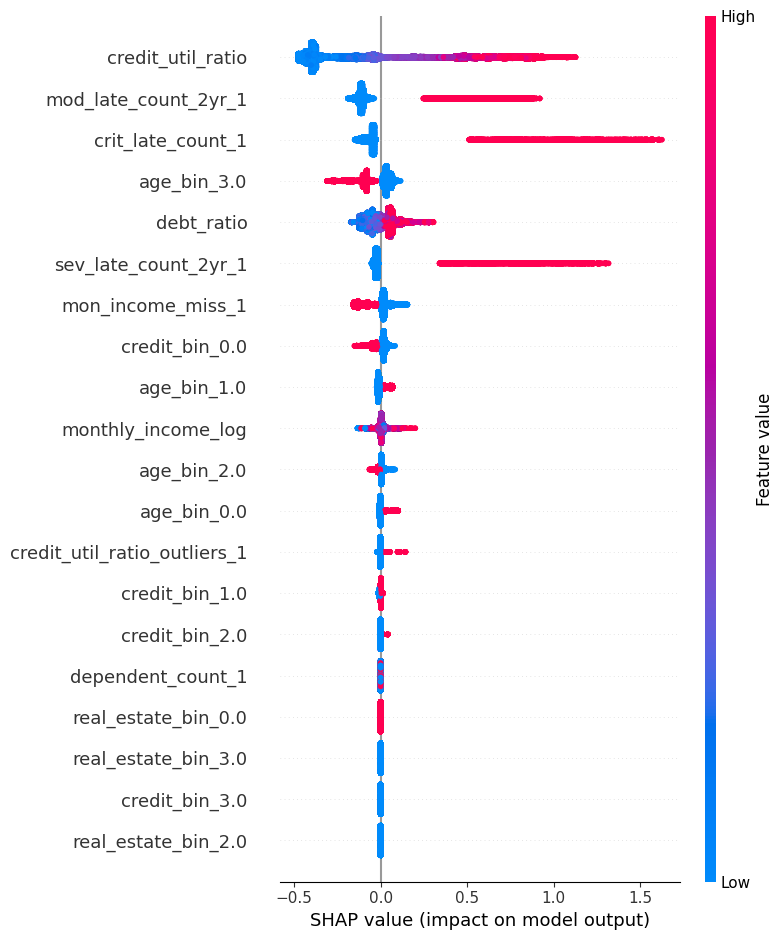

In [79]:
shap.summary_plot(train_shap_values, X_train_enc)

### **10. Final Results + Reflection**

The classification report shows that the final model demonstrates strong predictions for the negative class, with the highest precision score (0.98). This indicates that the majority of negative cases are correctly identified by the model. Recall is at a moderate level (0.80), and the F1-score is also high (0.86). A high precision score is expected given the significant class imbalance favoring the negative group.

For positive predictions, the model shows a higher recall (0.80) but notably lower precision (0.20) and F1-score (0.32). The higher recall indicates the model is generally sensitive to positive cases, resulting in limited false negatives. However, the lower precision means there is a greater risk of false positives.

Corresponding to these results, the confusion matrix shows more false positives (0.23% of total negative cases) than false negatives (0.20% of total positive cases). Similarly, there are more true negatives (0.77% of total negative cases) than true positives (0.80% of total positive cases).

In the context of credit fraud detection, recall (sensitivity) is prioritized over precision because it is critical to identify all potential fraud cases. The drawback of lower precision means the model may incorrectly flag some legitimate cases as fraud (false positives). However, when issuing credit loans, the greater risk lies in missing fraudulent cases, making this trade-off acceptable.

In [ ]:
final_pipe.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('selectfrommodel', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline-1', ...), ('pipeline-2', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred = final_pipe.predict(X_test)

final_recall = recall_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Recall: 0.801729873586161
F1: 0.3173140223831468
Precision: 0.19780039395929086

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.77      0.86     41994
           1       0.20      0.80      0.32      3006

    accuracy                           0.77     45000
   macro avg       0.59      0.78      0.59     45000
weighted avg       0.93      0.77      0.83     45000


Confusion Matrix:
[[32220  9774]
 [  596  2410]]


### **Takeaways**

In [ ]:
print("Final Model : HistGradientBoostingClassifier")

print(f"Recall: {final_recall}")
print(f"Precision: {final_precision}")
print(f"F1: {final_f1}")

* The model that performed the best was HistGradientBoostingClassifer with hyperparameter optimization and feature selection. 
* The final model demonstrated strong recall (0.80), but lower precision and f1. However recall is prioritized because it focuses on ensuring all positive cases (potential fraud) are identified.
* The limitations of this model are potentially more cases of false positives (due to low precision) and the moderate-level of interpretably provided by the HistGradientBoostingClassifier model.
* The features that most influence a person's probability to commit credit fraud in the next 2 years includes Debt-to-Income ratio (DTI), previous fraud and current debts. 